# How do star ratings work for stays?

Source: https://www.airbnb.com/help/article/1257/how-do-star-ratings-work-for-stays


In addition to written reviews, guests can submit an overall star rating and a set of category star ratings for their stay.

Hosts can view their star ratings on their Progress page, under Reviews. Hosts using professional hosting tools can find reviews and quality details on their Performance page, under Quality.

Guests can give ratings on:

- **Overall experience.** Overall, how was the stay?
- **Cleanliness.** Did guests feel that the space was clean and tidy?
- **Accuracy.** How accurately did the listing page represent the space? For example, guests should be able to find up-to-date info and photos in the listing description.
- **Value.** Did the guest feel that the listing provided good value for the price?
- **Communication.** How well did you communicate before and during the stay? Guests often care that their host responds quickly, reliably, and frequently to their messages and questions.
- **Check-in.** How smoothly did check-in go?
- **Location.** How did guests feel about the neighborhood? This may mean that there's an accurate description for proximity and access to transportation, shopping centers, city center, etc., and a description that includes special considerations, like noise, and family safety.
- **Amenities.** How did guests feel about the amenities that were available during their stay? Guests often care that all the amenities listed are available, working, and in good condition.

In each category, hosts are able to see how often they get 5 stars, how guests rated nearby hosts, and, in some cases, tips to help improve the listing.

The number of stars displayed at the top of a listing page is an aggregate of the primary scores guests have given for that listing. At the bottom of a listing page there's an aggregate for each category rating. A host needs to receive star ratings from at least 3 guests before their aggregate score appears.

## Our contribution

- Determine what type of rating contributes the most to predicting price (WIP)
- Determine polarity in reviews (done)
- Determine the connection between review's polarity and rating (WIP)

In [30]:
import pandas as pd
import datetime
from re import sub
import warnings

from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

import numpy as np

warnings.filterwarnings("ignore")

import seaborn as sns
# import matplotlib as plt
import matplotlib.pyplot as plt

from yellowbrick.features import rank2d
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Importing Data

In [15]:
df_listings = pd.read_csv("../../data/new-york-city-airbnb-open-data/listings.csv")
df_cal = pd.read_csv("../../data/new-york-city-airbnb-open-data/calendar.csv")
df_reviews_w_polarity = pd.read_csv('output/reviews_with_sentiment_and_lang.csv')

In [16]:
cols_to_keep = ['id','host_acceptance_rate','number_of_reviews',
                'number_of_reviews_ltm','review_scores_rating', 
                'review_scores_accuracy','review_scores_cleanliness', 
                'review_scores_checkin', 'review_scores_communication',
                'review_scores_location', 'review_scores_value','price']

df_listings = df_listings[cols_to_keep]

## Cleaning and setting up the target variable

In [17]:
# renaming id column
df_listings.rename(columns={"id": "listing_id"}, inplace=True)

# formatting price to float values
df_listings.price = [float(sub(r'[^\d.]', '', r['price'])) for i, r in df_listings.iterrows()]

In [18]:
df_listings.head()

,listing_id,host_acceptance_rate,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,2060,50%,1,0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0
1,2595,38%,48,5,94.0,9.0,9.0,10.0,10.0,10.0,9.0,225.0
2,3831,96%,313,69,90.0,9.0,9.0,10.0,10.0,10.0,8.0,89.0
3,5099,71%,78,8,90.0,10.0,9.0,10.0,10.0,10.0,9.0,200.0
4,5114,NaN,75,0,94.0,10.0,10.0,10.0,10.0,10.0,10.0,94.0


In [19]:
# remove null values
df_listings = df_listings.dropna()

# drop columns
df_listings = df_listings.drop(['listing_id', 'host_acceptance_rate'], axis=1)

In [20]:
df_listings.head()

,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
1,48,5,94.0,9.0,9.0,10.0,10.0,10.0,9.0,225.0
2,313,69,90.0,9.0,9.0,10.0,10.0,10.0,8.0,89.0
3,78,8,90.0,10.0,9.0,10.0,10.0,10.0,9.0,200.0
5,50,1,90.0,8.0,8.0,10.0,10.0,9.0,9.0,60.0
6,470,54,84.0,9.0,7.0,9.0,9.0,10.0,8.0,79.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132287f50>,
      dtype=object)

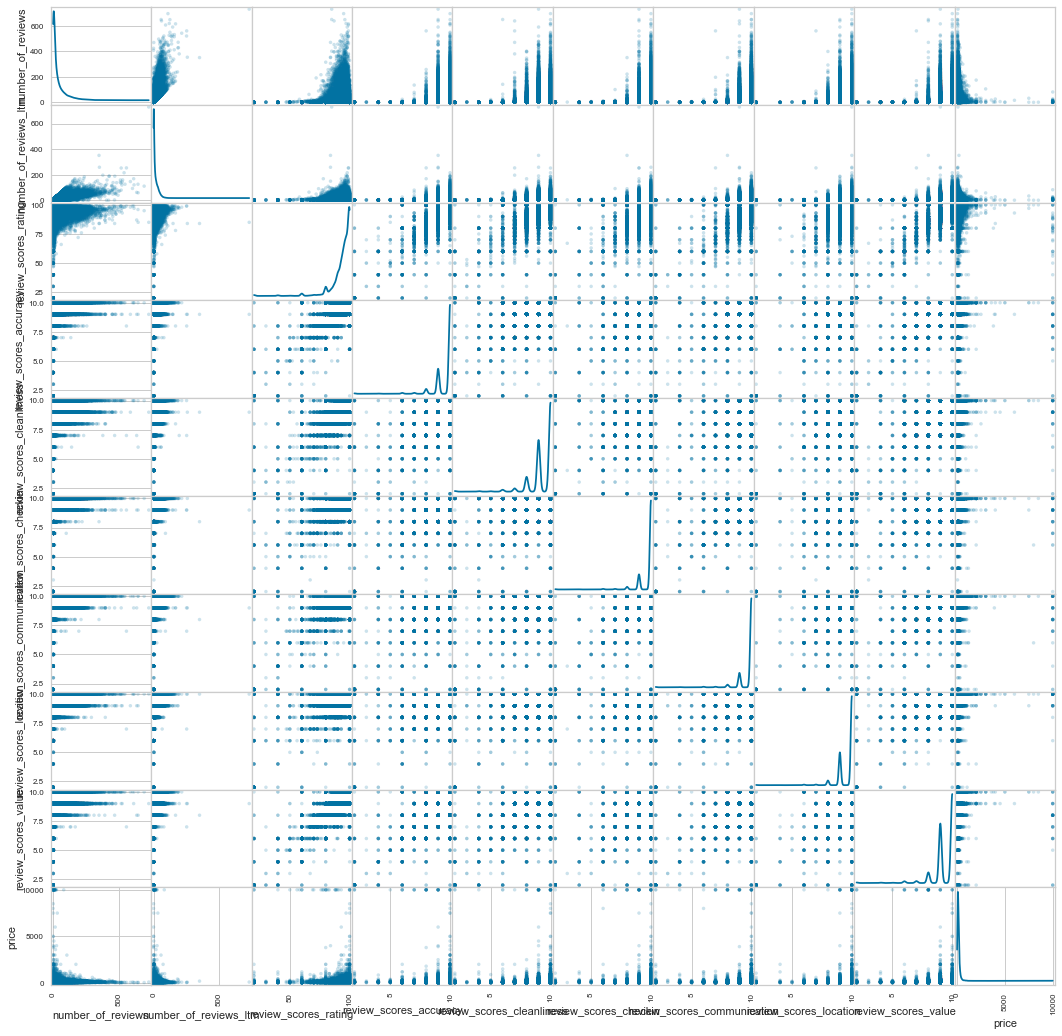

In [21]:
# areas = energy[['glazing_area','roof_area','surface_area','wall_area']]
from pandas.plotting import scatter_matrix
scatter_matrix(df_listings, alpha=0.2, figsize=(18,18), diagonal='kde')

## Defining the target and the features

In [22]:
# target
y = df_listings.price

# features
X = df_listings.loc[:, df_listings.columns != 'price']

In [23]:
y.shape

(31107,)

## Splitting training and testing

In [24]:
Xr_train, Xr_test, yr_train, yr_test = tts(X, y, test_size=0.2)

## Linear Regression

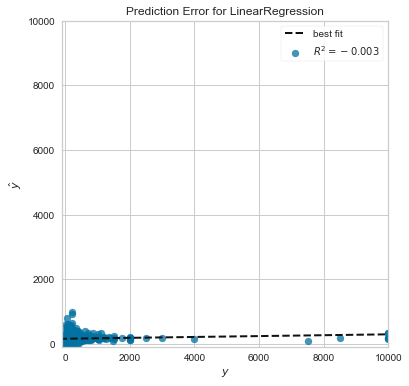

In [27]:
from sklearn.linear_model import LinearRegression

model_reg = LinearRegression()
model_reg.fit(Xr_train, yr_train)

_, ax = plt.subplots(figsize=(9,6))
_ = prediction_error(model_reg, Xr_test, yr_test, is_fitted=True, ax=ax, identity=False)

## Feature Importance for Regression

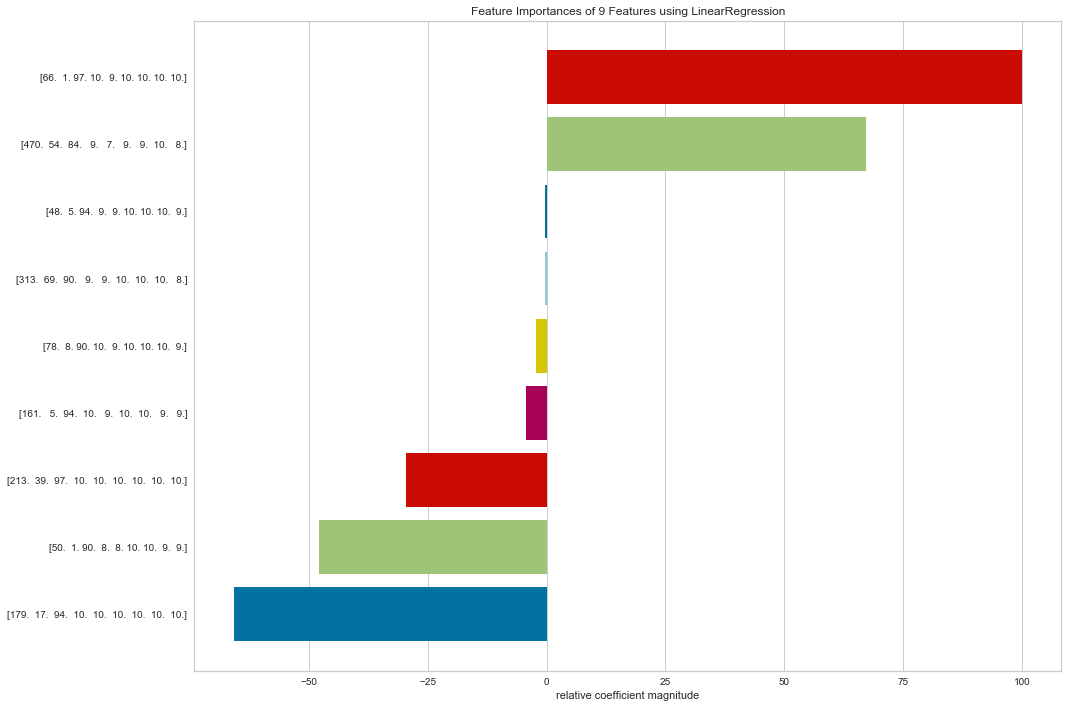

In [32]:
viz = FeatureImportances(model_reg, labels=X, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

## Random Forest

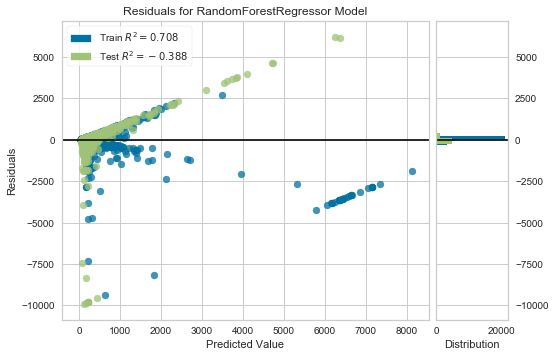

In [26]:
model = RandomForestRegressor()
oz = ResidualsPlot(model)

oz.fit(Xr_train, yr_train)
oz.score(Xr_test, yr_test)
_ = oz.show()